In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor

import sys

sys.path.append('../okko')
from data_preprocess import load_and_preprocess_data

In [3]:
(train_x, train_y, test_x) = load_and_preprocess_data()

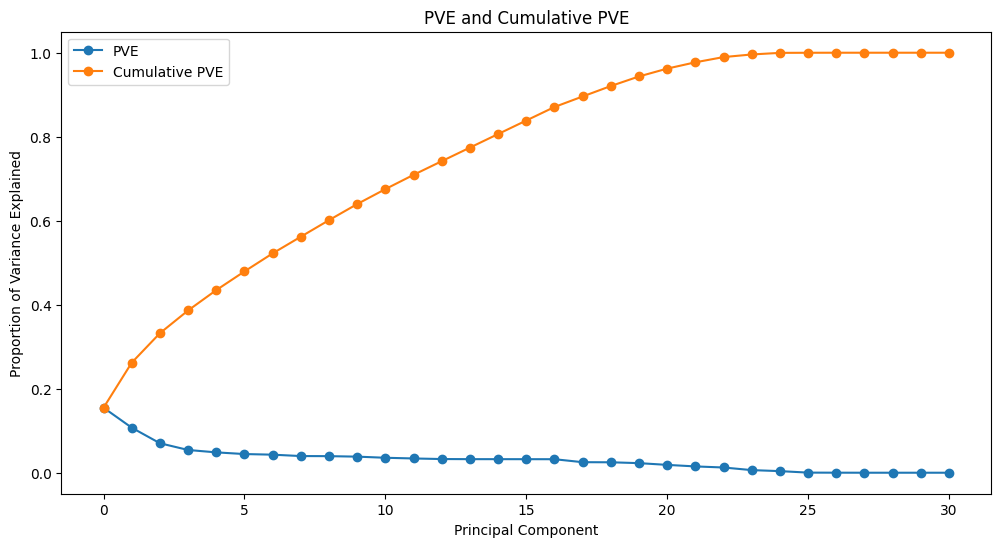

In [70]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(train_x)

pca = PCA()
Xpca = pca.fit_transform(X_train_scaled)

pve_scaled = pca.explained_variance_ratio_
cum_pve_scaled = np.cumsum(pve_scaled)

plt.figure(figsize=(12, 6))
plt.plot(pve_scaled, label="PVE", marker='o')
plt.plot(cum_pve_scaled, label="Cumulative PVE", marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.legend()
plt.title('PVE and Cumulative PVE')
plt.show()

In [26]:
def PCA_component_selection(
        model,
        X_train: pd.DataFrame,
        y_train: pd.Series):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    best_r2 = -2
    r2_scores = []
    mse_scores = []

    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_train_scaled = X_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1)).ravel()

    for n_components in range(1,X_train_scaled.shape[1] + 1):
        pca = PCA(n_components=n_components)
        Xpca = pca.fit_transform(X_train_scaled)
        scores = cross_validate(
            model,
            Xpca,
            y_train_scaled,
            scoring={'r2': 'r2', 'mse': 'neg_mean_squared_error'},
            cv=kf,
            n_jobs=-1
        )
        r2_scores.append(np.mean(scores['test_r2']))
        mse_scores.append(np.mean(scores['test_mse']))
    return {"Num_of_Components":[range(1,X_train_scaled.shape[1] + 1)], "r2_scores":r2_scores, "mse_scores":mse_scores}            

In [42]:
models = {"Dummy": DummyRegressor(strategy='mean'),
          "RandomForest": RandomForestRegressor(n_jobs=-1),
          "SVR": SVR(),
          "GradientBoosting": HistGradientBoostingRegressor()}

In [43]:
results = {}
print(models)
for name in models.keys():
    print(name)
    result = PCA_component_selection(models[name],train_x,train_y)
    results[name] = result


{'Dummy': DummyRegressor(), 'RandomForest': RandomForestRegressor(n_jobs=-1), 'SVR': SVR(), 'GradientBoosting': HistGradientBoostingRegressor()}
Dummy
RandomForest
SVR
GradientBoosting


In [ ]:
best_components = []

for name,result in results.items():
    num_components = list(range(1, len(result["r2_scores"]) + 1))
    
    best_r2_idx = np.argmax(result["r2_scores"])
    best_mse_idx = np.argmax(result["mse_scores"])
    
    best_components.append({
        "Model": name,
        "Best_r2_components": num_components[best_r2_idx]-1,
        "Best_r2_score": result["r2_scores"][best_r2_idx],
        "Best_mse_components": num_components[best_mse_idx],
        "Best_mse_score": result["mse_scores"][best_mse_idx]
    })

best_components_df = pd.DataFrame(best_components)
best_components_df.to_csv("best_components_results.csv", index=False)

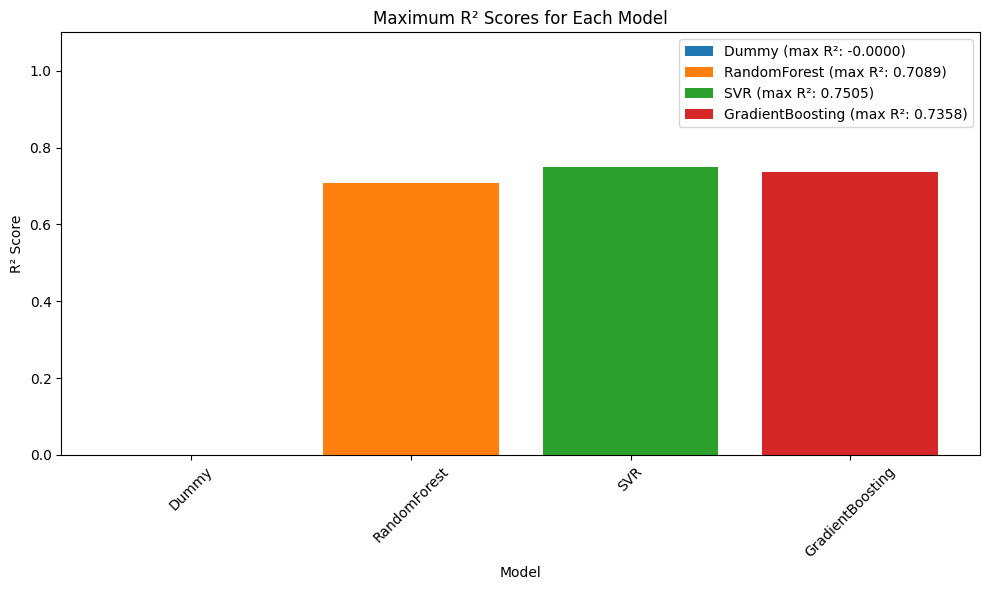

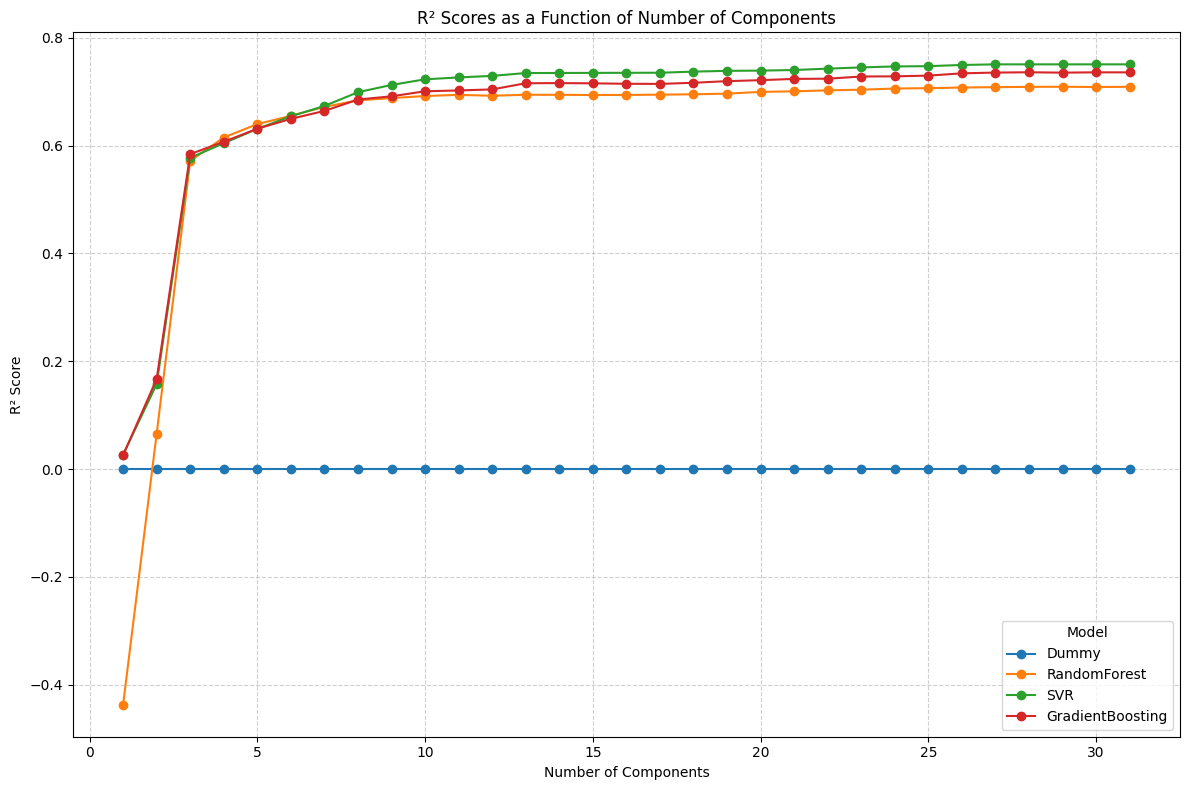

In [48]:
import matplotlib.pyplot as plt

models = [name for name,model in results.items()]
num_components = range(1, train_x.shape[1] + 1)
r2_scores_by_model = [result["r2_scores"] for name,result in results.items()]

plt.figure(figsize=(10, 6))
for model, r2_scores in zip(models, r2_scores_by_model):
    plt.bar(model, max(r2_scores), label=f"{model} (max R²: {max(r2_scores):.4f})")

plt.title("Maximum R² Scores for Each Model")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.ylim(0, 1.1)  
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
for model, r2_scores in zip(models, r2_scores_by_model):
    plt.plot(num_components, r2_scores, label=model, marker='o')

plt.title("R² Scores as a Function of Number of Components")
plt.ylabel("R² Score")
plt.xlabel("Number of Components")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Model", loc="best")
plt.tight_layout()
plt.show()

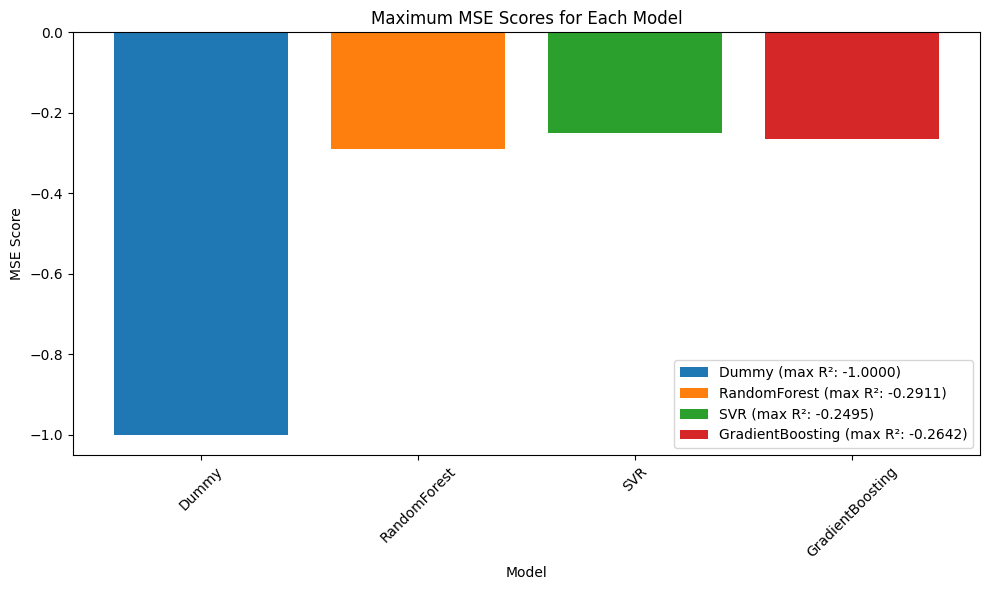

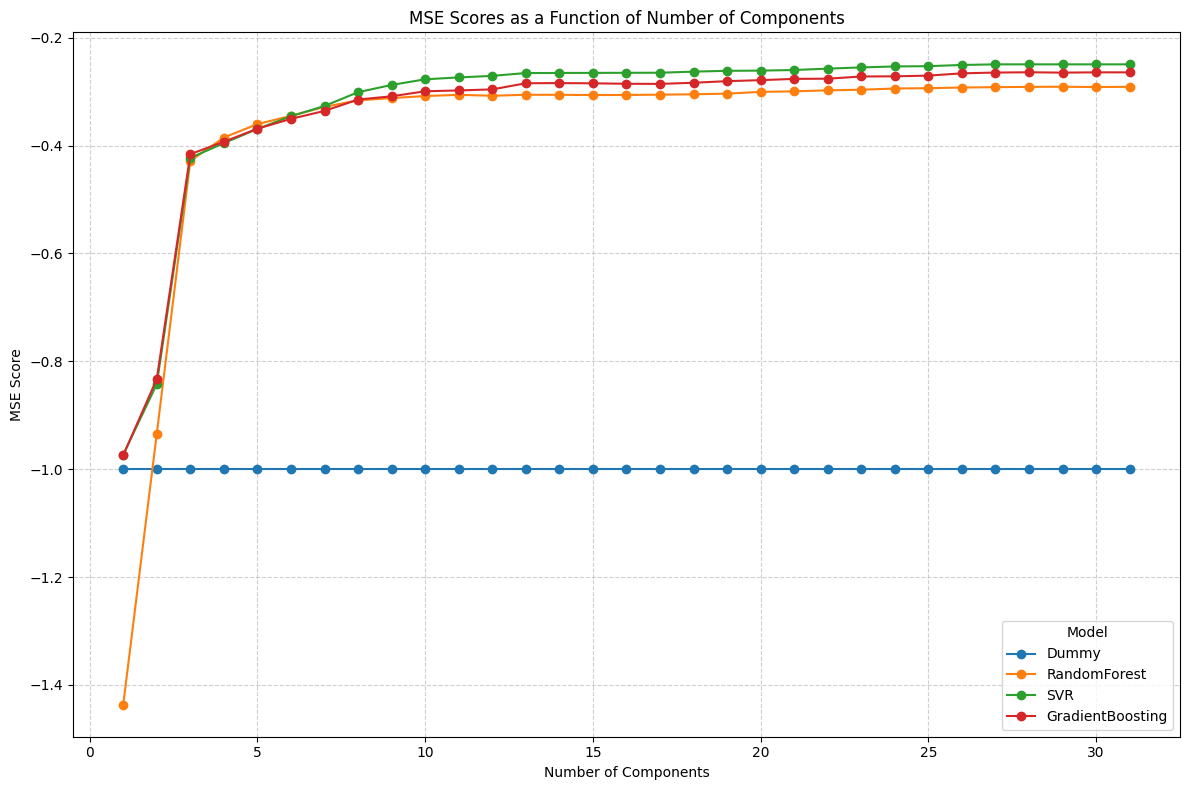

In [51]:
models = [name for name,model in results.items()]
num_components = range(1, train_x.shape[1] + 1)
mse_scores_by_model = [result["mse_scores"] for name,result in results.items()]

plt.figure(figsize=(10, 6))
for model, mse_scores in zip(models, mse_scores_by_model):
    plt.bar(model, max(mse_scores), label=f"{model} (max R²: {max(mse_scores):.4f})")

plt.title("Maximum MSE Scores for Each Model")
plt.ylabel("MSE Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
for model, mse_scores in zip(models, mse_scores_by_model):
    plt.plot(num_components, mse_scores, label=model, marker='o')

plt.title("MSE Scores as a Function of Number of Components")
plt.ylabel("MSE Score")
plt.xlabel("Number of Components")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Model", loc="best")
plt.tight_layout()
plt.show()

In [66]:
best_svr_r2 = np.max(results["SVR"]["r2_scores"])
i=0
print(best_svr_r2)
for r2 in results["SVR"]["r2_scores"]: 
    i += 1
    print(i,r2)
    if r2 >= 0.999*best_svr_r2:
        print(i)
        break


0.7505227276642026
1 0.026965843039632877
2 0.15767487133763144
3 0.5771396079234324
4 0.6043711941080124
5 0.630910670677647
6 0.6543194761768099
7 0.6733297795266402
8 0.6988468824941718
9 0.7123250591782262
10 0.7227774992520519
11 0.7262807466125913
12 0.7291489322119169
13 0.7343845224313202
14 0.7345368556224493
15 0.7346740859441234
16 0.7348418627850201
17 0.7349621654358984
18 0.7370306302783756
19 0.7385063677039838
20 0.7388928006710916
21 0.7400062171551681
22 0.7425889147961889
23 0.7448392094444403
24 0.7466464795938208
25 0.7471600080676752
26 0.7493792830919175
27 0.7505200800895231
27
